In [5]:
import json
import numpy as np
import os
import sys
from pathlib import Path
import json

# Add the correct Jorg package path
jorg_src_path = os.path.join(os.path.dirname(os.getcwd()), 'Korg.jl/jorg/src')
if jorg_src_path not in sys.path:
    sys.path.insert(0, jorg_src_path)

print(f"Added to Python path: {jorg_src_path}")

# Try to import Jorg continuum functions with comprehensive error handling
continuum_available = False
constants_available = False

print("Attempting to import Jorg functions...")
# Add Jorg to path
from jorg.statmech.eos import gas_pressure, total_pressure
from jorg.lines.opacity import calculate_line_opacity_korg_method

def load_marcs_model(atmosphere_file):
    """Load MARCS atmosphere data"""
    with open(atmosphere_file, 'r') as f:
        atmosphere_data = json.load(f)
    
    # Get layer closest to tau_5000 = 1 (photosphere)
    layer = min(atmosphere_data['atmosphere']['layers'], 
                key=lambda x: abs(x['tau_5000'] - 1.0))
    
    return {
        'temperature': layer['temperature'],
        'electron_density': layer['electron_density'],
        'number_density': layer['number_density']
    }

Added to Python path: /Users/jdli/Project/Korg.jl/jorg/src
Attempting to import Jorg functions...


In [6]:
def load_marcs_model(atmosphere_file):
    """Load MARCS atmosphere data"""
    with open(atmosphere_file, 'r') as f:
        atmosphere_data = json.load(f)
    
    # Get layer closest to tau_5000 = 1 (photosphere)
    layer = min(atmosphere_data['atmosphere']['layers'], 
                key=lambda x: abs(x['tau_5000'] - 1.0))
    
    return {
        'temperature': layer['temperature'],
        'electron_density': layer['electron_density'],
        'number_density': layer['number_density']
    }

In [8]:
def calculate_eos(atmosphere_params):
    """Calculate gas and total pressure using Jorg EOS"""
    temp = atmosphere_params['temperature']
    n_density = atmosphere_params['number_density']
    e_density = atmosphere_params['electron_density']
    
    gas_press = gas_pressure(n_density, temp)
    total_press = total_pressure(n_density, e_density, temp)
    
    return {
        'gas_pressure': gas_press,
        'total_pressure': total_press
    }

def load_linelist(linelist_file):
    """Load atomic/molecular line data"""
    with open(linelist_file, 'r') as f:
        return json.load(f)

In [9]:
def calculate_total_opacity(atmosphere_file, linelist_file, wavelength):
    """
    Calculate total opacity at given wavelength
    
    Args:
        atmosphere_file: Path to MARCS atmosphere JSON
        linelist_file: Path to linelist JSON  
        wavelength: Wavelength in Angstroms
        
    Returns:
        float: Total opacity in cm^-1
    """
    # Load data
    atm_params = load_marcs_model(atmosphere_file)
    eos_params = calculate_eos(atm_params)
    linelist = load_linelist(linelist_file)
    
    # Atmospheric parameters
    temperature = atm_params['temperature']
    electron_density = atm_params['electron_density']
    hydrogen_density = atm_params['number_density'] * 0.9  # ~90% H
    
    # Line parameters (example Fe line)
    excitation_potential = 3.0  # eV
    log_gf = -2.0              # oscillator strength
    abundance = 7.5e-5         # Fe/H ratio
    microturbulence = 2.0      # km/s
    
    # Calculate opacity over small wavelength range
    wavelengths = np.linspace(wavelength - 1.0, wavelength + 1.0, 100)
    
    opacity = calculate_line_opacity_korg_method(
        wavelengths=wavelengths,
        line_wavelength=wavelength,
        excitation_potential=excitation_potential,
        log_gf=log_gf,
        temperature=temperature,
        electron_density=electron_density,
        hydrogen_density=hydrogen_density,
        abundance=abundance,
        microturbulence=microturbulence
    )
    
    # Return central wavelength opacity
    return opacity[len(wavelengths) // 2]



In [10]:
# File paths
atmosphere_file = '/Users/jdli/Project/Korg.jl/jorg_related_files/marcs_data_for_jorg.json'
linelist_file = '/Users/jdli/Project/Korg.jl/jorg_related_files/galah_linelist_for_jorg.json'
wavelength = 5000.0  # Angstroms

# Calculate opacity
try:
    total_opacity = calculate_total_opacity(atmosphere_file, linelist_file, wavelength)
    print(f"Total opacity at {wavelength} Å: {total_opacity:.3e} cm^-1")
except Exception as e:
    print(f"Error: {e}")

Total opacity at 5000.0 Å: 5.054e-04 cm^-1


In [12]:
wave_range = np.linspace(4000, 7000, 100)  # Example wavelength range
try:
    opacity_values = [calculate_total_opacity(atmosphere_file, linelist_file, wave) for wave in wave_range]
    print("Opacity values calculated successfully.")
except Exception as e:
    print(f"Error calculating opacity values: {e}")

Opacity values calculated successfully.


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'Opacity (cm$^{-1}$)')

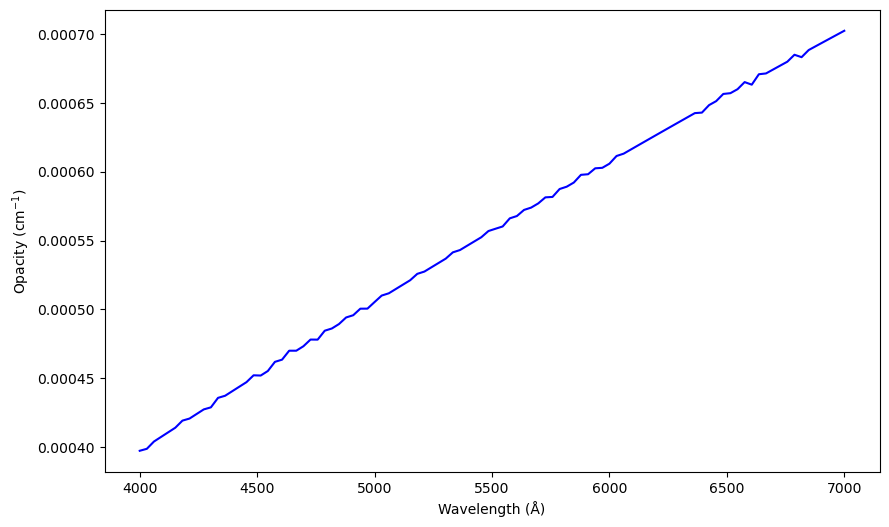

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wave_range, opacity_values, label='Total Opacity', color='blue')
ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Opacity (cm$^{-1}$)')


In [24]:
import pandas as pd

korg_opacity = pd.read_csv('/Users/jdli/Project/Korg.jl/korg_working_apis_opacity_4000_7000.csv')
korg_opacity.head()

,wavelength_angstrom,continuum_opacity_cm_inv,line_opacity_cm_inv,total_opacity_cm_inv
0,4000.000000,4.669209e-11,0.0,4.669209e-11
1,4030.303030,4.669209e-11,0.0,4.669209e-11
2,4060.606061,4.669209e-11,0.0,4.669209e-11
3,4090.909091,4.669209e-11,0.0,4.669209e-11
4,4121.212121,4.669209e-11,0.0,4.669209e-11


Text(0, 0.5, 'Opacity (cm$^{-1}$)')

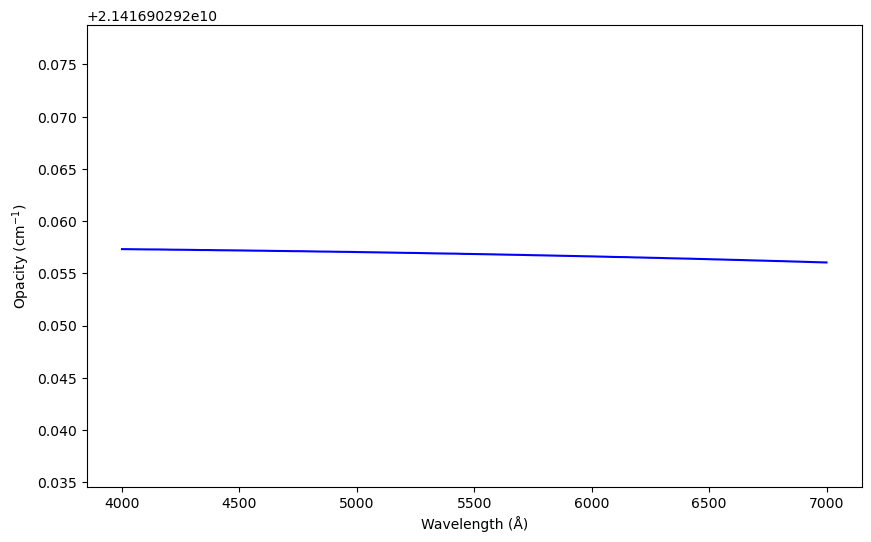

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wave_range, 1/korg_opacity['total_opacity_cm_inv'], label='Total Opacity', color='blue')
ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Opacity (cm$^{-1}$)')